**Imports & Settings**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
pd.set_option("display.max_columns", None)

**Load Clean Dataset**

In [ ]:
df = pd.read_csv("/content/master_with_shocks.csv")

In [ ]:
df.head()
df[["year", "sector", "prod_shock"]].drop_duplicates().head(10)

,year,sector,prod_shock
0,2005,Basic metals,0
1,2006,Basic metals,0
2,2007,Basic metals,0
3,2008,Basic metals,1
4,2009,Basic metals,0
5,2010,Basic metals,0
6,2011,Basic metals,0
7,2012,Basic metals,0
8,2005,Chemicals and chemical products,0
9,2006,Chemicals and chemical products,0


**Sort Data**

In [ ]:
df = df.sort_values(["sector", "year"]).reset_index(drop=True)

**Define Event Window**

In [ ]:
event_window = 3   # years before and after shock

**Construct Event-Level Dataset (CORE STEP)**

**Logic**

Shocks are aggregate (year-based)

Sector responses are sector-specific

Each shock contributes one mini time-series per sector

In [ ]:
events = []

shock_years = df[df["prod_shock"] == 1]["year"].unique()

for shock_year in shock_years:
    for sec in df["sector"].unique():
        sector_data = df[df["sector"] == sec]

        for t in range(-event_window, event_window + 1):
            year_t = shock_year + t
            row = sector_data[sector_data["year"] == year_t]

            if not row.empty:
                events.append({
                    "sector": sec,
                    "shock_year": shock_year,
                    "event_time": t,
                    "sector_output_growth": row["sector_output_growth"].values[0]
                })

In [ ]:
event_df = pd.DataFrame(events)

In [ ]:
event_df.head()
event_df["event_time"].value_counts().sort_index()

,count
event_time,
-3,26
-2,26
-1,26
0,26
1,26
2,26
3,26


**Average Responses**

In [ ]:
event_avg = (
    event_df
    .groupby(["sector", "event_time"])["sector_output_growth"]
    .mean()
    .reset_index()
)

**Select Representative Sectors**

In [ ]:
key_sectors = [
    "Manufacturing",
    "Mining and Quarrying",
    "Electricity",
    "Chemicals and chemical products",
    "Motor vehicles, trailers and semi-trailers"
]

event_plot = event_avg[event_avg["sector"].isin(key_sectors)]

**Event-Study Plot**

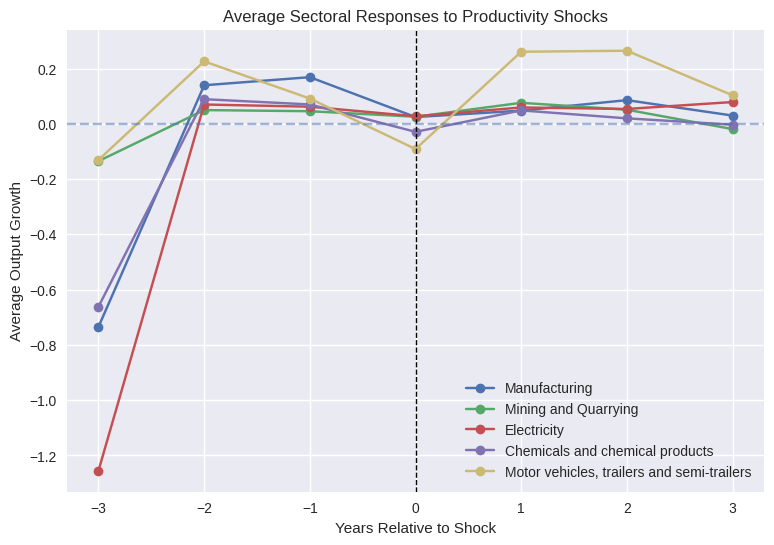

In [ ]:
plt.figure(figsize=(9,6))

for sec in key_sectors:
    s = event_plot[event_plot["sector"] == sec]
    plt.plot(
        s["event_time"],
        s["sector_output_growth"],
        marker="o",
        label=sec
    )

plt.axvline(0, linestyle="--", color="black", linewidth=1)
plt.axhline(0, linestyle="--", alpha=0.5)

plt.title("Average Sectoral Responses to Productivity Shocks")
plt.xlabel("Years Relative to Shock")
plt.ylabel("Average Output Growth")
plt.legend()
plt.show()

**Persistence Check**

In [ ]:
persistence = (
    event_avg[event_avg["event_time"] >= 0]
    .groupby("sector")["sector_output_growth"]
    .mean()
    .sort_values(ascending=False)
)

persistence

,sector_output_growth
sector,
Other transport equipment,0.150793
"Motor vehicles, trailers and semi-trailers",0.134170
"Radio, TV and communication equipment and apparatus",0.113271
"Fabricated metal products, except machinery and equipment",0.086565
"Publishing, printing and reproduction of recorded media",0.079646
Rubber and plastics products,0.076936
Machinery and equipment n.e.c.,0.066421
Electricity,0.054616
Basic metals,0.051560


**Save Event Data**

In [ ]:
import os

output_dir = "../outputs"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
persistence.to_csv(os.path.join(output_dir, "shock_persistence.csv"))

In [ ]:
event_avg.to_csv("../outputs/event_study_avg.csv", index=False)